In [4]:
import yaml
import os

class Vars:
    _data = {}
    _path = None

    @classmethod
    def initialize(cls, path):
        cls._path = path
        cls._data = cls.load()

    @classmethod
    def load(cls):
        if cls._path and os.path.exists(cls._path):
            with open(cls._path, 'r') as f:
                return yaml.safe_load(f)
        return {}

    @classmethod
    def get(cls, key):
        if key not in cls._data:
            raise KeyError(f"Variable {key} not found")
        return cls._data[key]

    @classmethod
    def set(cls, key, value):
        cls._data[key] = value
        with open(cls._path, 'w') as f:
            yaml.safe_dump(cls._data, f, default_flow_style=False)


In [5]:
Vars.initialize('vars.yaml')

In [6]:
Vars.set("ENV", "prod")
Vars.set("MATRICE_ACCESS_KEY_ID", "CL0F6ORVHBJHATJ047TZ7")
Vars.set("MATRICE_SECRET_ACCESS_KEY", "XFKI2KM8POMGRVUTXJSPP")
Vars.set("MATRICE_ACCOUNT_NUMBER", "9782886768719887307619115")

In [7]:
import os
os.environ['ENV'] = Vars.get('ENV')
access_key = Vars.get('MATRICE_ACCESS_KEY_ID')
secret_key = Vars.get('MATRICE_SECRET_ACCESS_KEY')
account_number = Vars.get('MATRICE_ACCOUNT_NUMBER')

In [8]:
from matrice.session import Session
from matrice.projects import Projects
from matrice.dataset import Dataset
from matrice.models import Model
from matrice.deployment import Deployment
from matrice.exported_model import ExportedModel
import sys
import os

In [9]:
session_instance = Session(account_number=account_number, access_key=access_key, secret_key=secret_key)
print("A Session has been initialized:", session_instance)

A Session has been initialized: <matrice.session.Session object at 0x00000280FC62E7A0>


In [10]:
projects_list, msg = session_instance.list_projects(project_type="instance_segmentation")

# Check if there is a message or error
if msg:
    print(f"Message: {msg}")

# Print the projects in a formatted manner
for project_name, project_instance in projects_list.items():
    print(f"Project Name: {project_name} | Project ID: {project_instance.project_id}") #To fix: ERROR: May return none and give error if proj is empty list

Message: Projects fetched successfully
Project Name: intrusion_fencing | Project ID: 682da07c0a1d0e31e05feb85
Project Name: traffic_density | Project ID: 682ad0870a1d0e31e05fdec9
Project Name: pothole_segmentation | Project ID: 682c34770a1d0e31e05fe361
Project Name: final_theft | Project ID: 68231ab80a1d0e31e05fbded
Project Name: liver_tum | Project ID: 682c3e5b0a1d0e31e05fe3af
Project Name: field_water_segmentation | Project ID: 6826f0240a1d0e31e05fce17
Project Name: Brain_tumor_sef_final | Project ID: 6825a95f0a1d0e31e05fc731
Project Name: road_view_seg | Project ID: 6826e9b90a1d0e31e05fcdcf
Project Name: kidney_tumor | Project ID: 6825ba920a1d0e31e05fc7a6
Project Name: brain tumor segmentation | Project ID: 682556ce0a1d0e31e05fc59d


In [11]:
project_name = "wound_seg"
for name, project_instance in projects_list.items():
    if name == project_name:
        projects_instance = Projects(session_instance, project_name=project_name)
        session_instance.update(projects_instance.project_id)
        print(f"Project '{project_name}' already exists. Initialized Projects instance.")
        project_exists = True
        break
    else:
        project_exists = False

if project_exists == False:
    print(f"Creating a new project: {project_name}")

Creating a new project: wound_seg


In [12]:
import pprint

name = project_name

# Function to create a project
def create_project():
    project_name = name
    input_type = "image"
    output_type = "instance_segmentation"

    enabled_platforms = {
        "matrice": True,
        "android": False,
        "ios": False,
        "tpu": False,
        "intelCPU": False,
        "gcloudGPU": False
    }

    resp, error = session_instance._create_project(project_name, input_type, output_type)
    if error:
        print(f"Error: {error}")
        return None, None
    else:
        print(f"Project created with ID: {resp['_id']}")
        return resp['_id'], resp['name']

# Check if project_id and project_name exist
project_id = None
project_name = None

if not project_exists:
    project_id, project_name = create_project()
else:
    project_id = projects_instance.project_id
    project_name = projects_instance.project_name
    print(f"Project already exists with ID: {project_id} and Name: {project_name}")


print("----------------------------")
print(f"Project ID: {project_id}")
print(f"Project Name: {project_name}")
print("----------------------------")


Project created with ID: 682daae50a1d0e31e05fec28
----------------------------
Project ID: 682daae50a1d0e31e05fec28
Project Name: wound_seg
----------------------------


In [13]:
Vars.set("project_name",project_name)
Vars.set("project_id", project_id)

In [14]:
session_instance.update(project_id)
project_instance = Projects(session_instance, project_name=project_name)
print("A Project class has been initialized",project_instance)

# From next time, for deployment run till here

A Project class has been initialized <matrice.projects.Projects object at 0x00000280FCB6FB80>


In [ ]:
dataset = project_instance.import_local_dataset(
    project_type='instance_segmentation',
    dataset_name='Road-Lane-Dataset',
    file_path = r"/content/road_lane_instance_segmentation.zip",
    dataset_type = "instance_segmentation",
    input_type = "mscoco"
) #THIS runs on backend. CHECK UI and then fetch ds id manually from UI

In [15]:
dataset=Dataset(session_instance,dataset_id='682dab4f77c12201804f8cdf') #To EDIT

In [16]:
dataset_id = dataset.dataset_id
# action_id = dataset_action.action_id

print(f"Dataset ID: {dataset_id}")
# print(f"Action ID: {action_id}")

Dataset ID: 682dab4f77c12201804f8cdf


In [17]:
Vars.set("dataset_id", dataset.dataset_id)

In [20]:
def print_dataset_info(dataset):

    dataset_id = dataset.dataset_details['_id']
    dataset_name = dataset.dataset_details['name']
    version_status = dataset.dataset_details.get("stats", [{}])[0].get("versionStatus")
    latest_version = dataset.dataset_details['latestVersion']
    no_of_samples = sum(version['versionStats']['total'] for version in dataset.dataset_details.get('stats', []))
    no_of_classes = len(dataset.dataset_details.get('stats', [{}])[0].get('classStat', {}))
    no_of_versions = len(dataset.dataset_details.get('allVersions', []))
    last_updated_at = dataset.dataset_details.get('updatedAt')

    print(f"Dataset ID: {dataset_id}")
    print(f"Dataset Name: {dataset_name}")
    print(f"Version Status: {version_status}")
    print(f"Latest Version: {latest_version}")
    print(f"Number of Samples: {no_of_samples}")
    print(f"Number of Classes: {no_of_classes}")
    print(f"Number of Versions: {no_of_versions}")
    print(f"Last Updated At: {last_updated_at}")

dataset.refresh()
print_dataset_info(dataset)

Dataset ID: 682dab4f77c12201804f8cdf
Dataset Name: Untitled Dataset 2025-05-21 16:00:14
Version Status: processed
Latest Version: v1.0
Number of Samples: 4005
Number of Classes: 1
Number of Versions: 1
Last Updated At: 2025-05-21T10:32:33.197Z


In [21]:
from matrice.model_store import get_all_model_families

resp , error , mesage = get_all_model_families( session_instance , project_id , project_type="instance_segmentation" )
print(error)
print("----List of available Detection models on platform----")
# Iterate through each model family in the response
for model_family in resp:
    # Extract _id and modelFamily (model family name)
    model_family_id = model_family.get('_id')
    name = model_family.get('modelFamily')

    # Print in formatted manner
    print(f"ID: {model_family_id}, Model Family Name: {name}")

None
----List of available Detection models on platform----
ID: 67625ff9d6db1ef9132e84e2, Model Family Name: YOLOv8_Instance_Segmentation
ID: 6762c9b45892e63f791b755d, Model Family Name: YOLOv9_Instance_Segmentation


In [22]:
from matrice.model_store import ModelFamily

model_family_id = "67625ff9d6db1ef9132e84e2" #To EDIT from previous result
# Initialize the ModelFamily instance after choosing a Model Family
model_family_instance = ModelFamily(session_instance, model_family_id=model_family_id) # ResNet
print("A ModelFamily instance has been initialized",model_family_instance)

A ModelFamily instance has been initialized <matrice.model_store.ModelFamily object at 0x00000280FCB61330>


In [23]:
# Fetch model architectures
import pprint
arch_resp, error, message = model_family_instance.get_model_archs()
if error:
    print(f"Error: {error}")
else:
    pprint.pprint(arch_resp)
    # Check if resp is a list or a dictionary
    if isinstance(arch_resp, list):
        # Iterate through each model info in the list
        for model_info in arch_resp:
            model_key = model_info["model_key"]
            model_arch_instance = model_info["model_arch_instance"]

            # Extract model information
            model_info_id = model_arch_instance.model_arch_id
            name = model_arch_instance.model_name
            key = model_arch_instance.model_key
            params = model_arch_instance.params_millions

            # Print in formatted manner
            print(f"ID: {model_info_id} |  Model Name: {name} | Model Key: {key} | Params in Millions: {params}")

    elif isinstance(arch_resp, dict):
        # Iterate through each model key in the dictionary
        for model_key, model_arch_instance in arch_resp.items():
            # Extract model information
            model_info_id = model_arch_instance.model_arch_id
            name = model_arch_instance.model_name
            key = model_arch_instance.model_key
            params = model_arch_instance.params_millions

            # Print in formatted manner
            print(f"ID: {model_info_id} | Model Name: {name} | Model Key: {key} | Params in Millions: {params}")

{'yolov8l_seg': <matrice.model_store.ModelArch object at 0x00000280FCB6EF50>,
 'yolov8m_seg': <matrice.model_store.ModelArch object at 0x00000280FCB6FB20>,
 'yolov8n_seg': <matrice.model_store.ModelArch object at 0x00000280FCB602E0>,
 'yolov8s_seg': <matrice.model_store.ModelArch object at 0x00000280FCB6FCA0>,
 'yolov8x_seg': <matrice.model_store.ModelArch object at 0x00000280FCB6FD60>}
ID: 67625ff9d6db1ef9132e84e3 | Model Name: YOLOv8 Instance Segmentation Nano | Model Key: yolov8n_seg | Params in Millions: 3.4
ID: 67625ff9d6db1ef9132e84e4 | Model Name: YOLOv8 Instance Segmentation Small | Model Key: yolov8s_seg | Params in Millions: 11.8
ID: 67625ff9d6db1ef9132e84e5 | Model Name: YOLOv8 Instance Segmentation Medium | Model Key: yolov8m_seg | Params in Millions: 27.3
ID: 67625ff9d6db1ef9132e84e6 | Model Name: YOLOv8 Instance Segmentation Large | Model Key: yolov8l_seg | Params in Millions: 46
ID: 67625ff9d6db1ef9132e84e7 | Model Name: YOLOv8 Instance Segmentation Xtra Large | Model Ke

In [24]:
from matrice.model_store import ModelArch
train_arch = 'yolov8s_seg' #To EDIT from previous result
print("Chosen Training Architecture :" ,train_arch)
model_arch_instance = arch_resp.get(train_arch)
print("Model Architecture instance initialized for chosen training architecture :", model_arch_instance)

Chosen Training Architecture : yolov8s_seg
Model Architecture instance initialized for chosen training architecture : <matrice.model_store.ModelArch object at 0x00000280FCB6FCA0>


In [25]:
import pprint
train_config = model_arch_instance.get_train_config()
print("-----Default Train Config------")
pprint.pprint(train_config)
print("--------------------------------")
print("-------Training instance initialized--------")
# print(train_instance)

-----Default Train Config------
{'action_config': {},
 'checkpoint_type': 'predefined',
 'is_autoML': False,
 'model_arch_id': '67625ff9d6db1ef9132e84e4',
 'model_checkpoint': 'auto',
 'model_config': {'batch_size': [16],
                  'cos_lr': [False],
                  'epochs': [50],
                  'learning_rate': [0.001],
                  'momentum': [0.95],
                  'optimizer': ['auto'],
                  'weight_decay': [0.0005]},
 'model_family_name': 'YOLOv8_Instance_Segmentation',
 'model_inputs': ['image'],
 'model_key': 'yolov8s_seg',
 'model_name': 'YOLOv8 Instance Segmentation Small',
 'model_outputs': ['instance_segmentation'],
 'params_millions': 11.8,
 'tuning_type': 'default'}
--------------------------------
-------Training instance initialized--------


In [26]:
model_config = train_config['model_config']

# Modify the model_config as needed
# modifications:
model_config['batch_size'] = [4]
model_config['epochs'] = [80]  #These are hyper-parameters and can be changed
model_config['learning_rate'] = [0.0001]
model_config['momentum'] = [0.99]
model_config['weight_decay'] = [0.0005]
model_config['optimizer']=['AdamW']
model_config['cos_lr']=[True]
'optimizer'


# Repass the modified model_config into the train_config
train_config['model_config'] = model_config

# Print the updated train_config
print("-----Updated Model Config------")
pprint.pprint(train_config['model_config'])
print("--------------------------------")

# Print the updated train_config
print("-----Updated Train Config------")
pprint.pprint(train_config)
print("--------------------------------")

-----Updated Model Config------
{'batch_size': [4],
 'cos_lr': [True],
 'epochs': [80],
 'learning_rate': [0.0001],
 'momentum': [0.99],
 'optimizer': ['AdamW'],
 'weight_decay': [0.0005]}
--------------------------------
-----Updated Train Config------
{'action_config': {},
 'checkpoint_type': 'predefined',
 'is_autoML': False,
 'model_arch_id': '67625ff9d6db1ef9132e84e4',
 'model_checkpoint': 'auto',
 'model_config': {'batch_size': [4],
                  'cos_lr': [True],
                  'epochs': [80],
                  'learning_rate': [0.0001],
                  'momentum': [0.99],
                  'optimizer': ['AdamW'],
                  'weight_decay': [0.0005]},
 'model_family_name': 'YOLOv8_Instance_Segmentation',
 'model_inputs': ['image'],
 'model_key': 'yolov8s_seg',
 'model_name': 'YOLOv8 Instance Segmentation Small',
 'model_outputs': ['instance_segmentation'],
 'params_millions': 11.8,
 'tuning_type': 'default'}
--------------------------------


In [27]:
train_resp , msg , err = project_instance.add_models_for_training(train_config,primary_metric='mAP@50',dataset_id=dataset.dataset_id,dataset_name=dataset.dataset_name,)
print("------------Model added for training----------")
pprint.pprint(train_resp)

[{'modelKey': 'yolov8s_seg', 'autoML': False, 'tuningType': 'default', 'modelCheckpoint': 'auto', 'checkpointType': 'predefined', '_idModelArch': '67625ff9d6db1ef9132e84e4', 'modelFamilyName': 'YOLOv8_Instance_Segmentation', 'actionConfig': {}, 'modelConfig': {'optimizer': ['AdamW'], 'cos_lr': [True], 'batch_size': [4], 'epochs': [80], 'learning_rate': [0.0001], 'momentum': [0.99], 'weight_decay': [0.0005]}, 'modelName': 'YOLOv8 Instance Segmentation Small', 'paramsInMillion': 11.8, 'modelInputs': ['image'], 'modelOutputs': ['instance_segmentation'], 'targetRuntime': ['PyTorch'], '_idDataset': '682dab4f77c12201804f8cdf', 'datasetVersion': 'v1.0', 'primaryMetric': 'mAP@50', 'datasetName': 'Untitled Dataset 2025-05-21 16:00:14', 'computeAlias': ''}]
{'success': True, 'code': 200, 'message': 'Success', 'serverTime': '2025-05-21T10:40:29Z', 'data': [{'_id': '682dad9dba25d9750f40e2d0', '_idDataset': '682dab4f77c12201804f8cdf', '_idActionStatus': '682dad9d0a1d0e31e05fec52', '_idModelFamily':

In [28]:
import time
from matrice.action import Action

# Define the action ID and the status you want to check
action_id = train_resp[0]['_idActionStatus']
success_status = 'SUCCESS'
time_sec = 90

# Function to check the status of the action
def check_action_status(S, action_id):
    action_instance = Action(S, action_id)
    print("---------------------")
    print(f"Action ID: {action_id}")
    print(f"Current Status: {action_instance.status}")
    print(f"Step Code: {action_instance.step_code}")
    print(f"Action service is : {action_instance.service_name}")
    print("---------------------")
    return action_instance.status

# Loop to check status every 2 minutes until it is 'success'
while True:
    status = check_action_status(session_instance, action_id)
    if status == success_status:
        print("Action status is 'success'. Model is successfully trained.")
        break
    else:
        print(f"Model is training. Waiting {time_sec} seconds before checking again.")
        time.sleep(time_sec)


---------------------
Action ID: 682dad9d0a1d0e31e05fec52
Current Status: ACK
Step Code: SCLS_QUE_PROC
Action service is : be-model
---------------------
Model is training. Waiting 90 seconds before checking again.
---------------------
Action ID: 682dad9d0a1d0e31e05fec52
Current Status: ACK
Step Code: SCLS_QUE_PROC
Action service is : be-model
---------------------
Model is training. Waiting 90 seconds before checking again.
---------------------
Action ID: 682dad9d0a1d0e31e05fec52
Current Status: OK
Step Code: SCLS_LNCH_CMPI
Action service is : be-model
---------------------
Model is training. Waiting 90 seconds before checking again.
---------------------
Action ID: 682dad9d0a1d0e31e05fec52
Current Status: OK
Step Code: SCLS_LNCH_CMPI
Action service is : be-model
---------------------
Model is training. Waiting 90 seconds before checking again.
---------------------
Action ID: 682dad9d0a1d0e31e05fec52
Current Status: OK
Step Code: JBSS_LCK
Action service is : be-model
--------------

In [29]:
model_id = train_resp[0]['_id']
print(f"Model ID from response data: {model_id}")


# Initialize the Model class with the model_id
model_instance = Model(session_instance, model_id)
print("A Model instance has been initialized : ", model_instance)

Model ID from response data: 682dad9dba25d9750f40e2d0
A Model instance has been initialized :  <matrice.models.Model object at 0x00000280FCE39630>


In [30]:
# Print the test score, validation score, and best epoch
print(f"Test Score: {model_instance.test_score}")
print(f"Validation Score: {model_instance.val_score}")
print(f"Best Epoch: {model_instance.best_epoch}")

Test Score: 0.6916822867010557
Validation Score: 0.6911173503475811
Best Epoch: -1


In [31]:
Vars.set("model_train_id", model_instance.model_id)

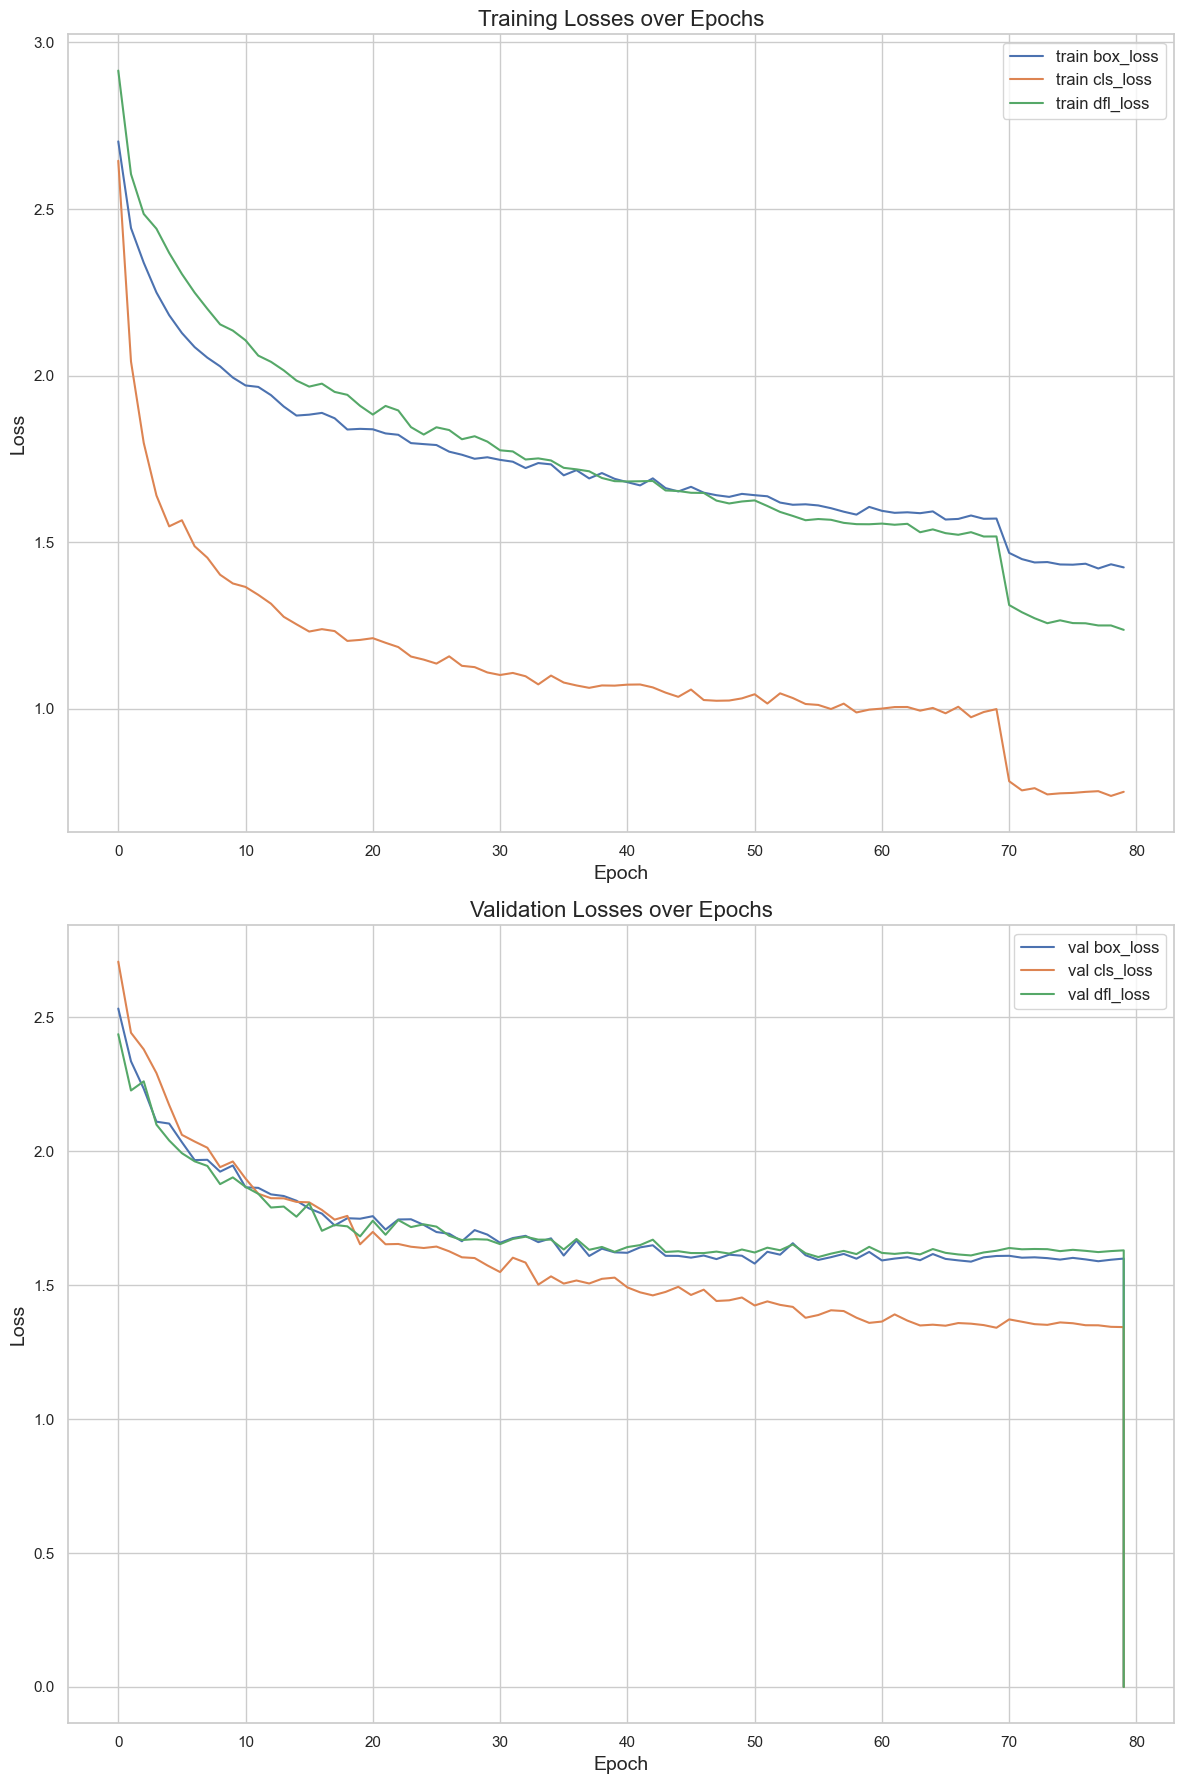

In [32]:
model_instance.plot_epochs_losses()

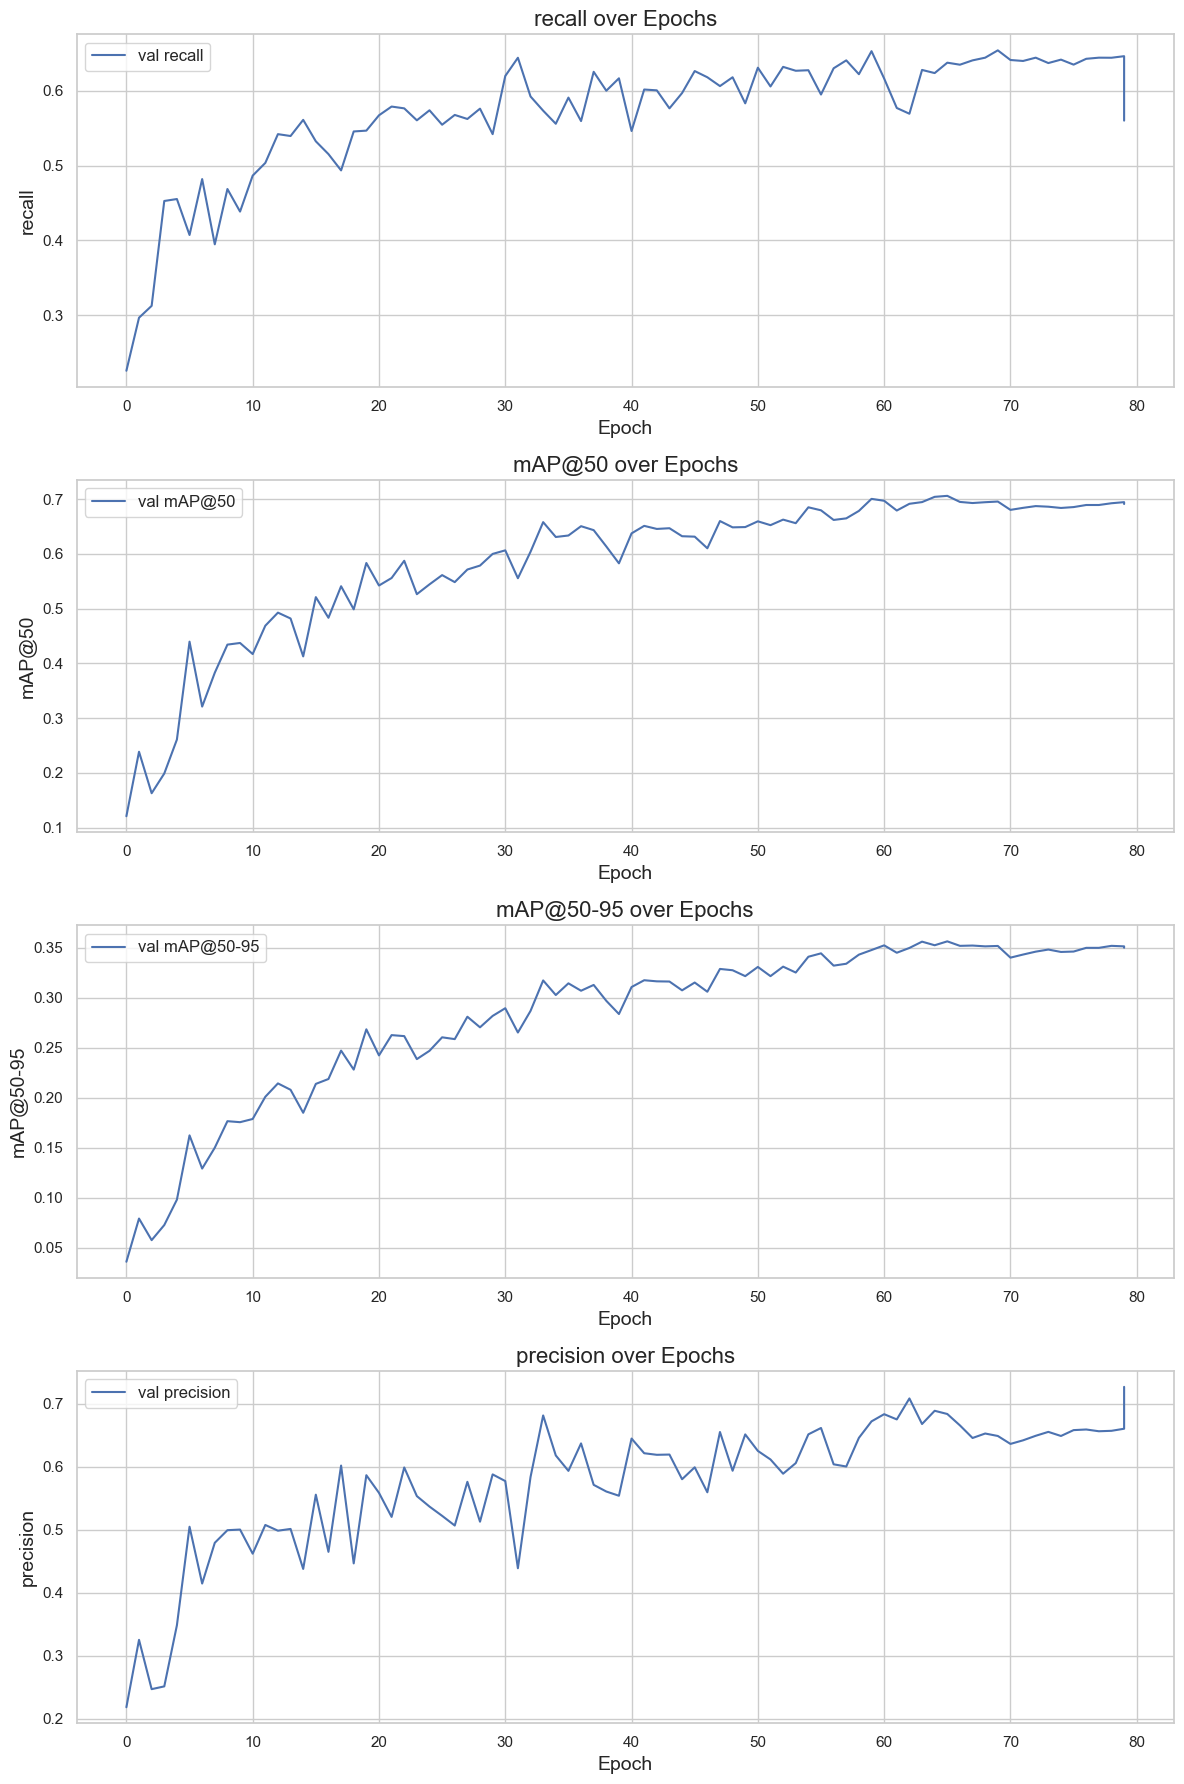

In [33]:
model_instance.plot_epochs_metrics()